In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate

\begin{align*}
    S_0^{SPX} &= 2921 \\
    S_0^{AMZN} &= 1971 \\
    \delta^{SPX} &= 1.8\% \\
    \delta^{AMZN} &= 1.9\% \\
    r &= 2.4\% \\
    T & = 0.296
\end{align*}

In [4]:
S0_1 = 2921 #SPX
S0_2 = 1971 #AMZN
delta_1 = 0.018
delta_2 = 0.019
r = 0.024
T = 0.296
rho = 0.5 # for monte-carlo
num_sim = 10000 # number of simulations

In [5]:
data = pd.read_excel("Impvols_SPX_AMZN.xlsx", usecols=[0,1,4,5], header=1).drop(0).reset_index(drop=True).\
            rename(axis=1,mapper={"amzn implied vols": "amzn_implied_vols",
                                 "spx implied vols": "spx_implied_vols"})
data.head()

,spx_strikes,spx_implied_vols,amzn_strikes,amzn_implied_vols
0,1500.0,0.460000,700.0,0.610300
1,1525.0,0.451075,710.0,0.603335
2,1550.0,0.443954,720.0,0.596944
3,1575.0,0.437649,730.0,0.591072
4,1600.0,0.431531,740.0,0.585658


In [6]:
np.size(data.spx_strikes.dropna())

241

In [7]:
def price_call(S, K, T, t, r, delta, sigma):
    d1 = 1/(sigma*np.sqrt(T-t))*np.log(S*np.exp(r*(T-t))/K) + sigma*np.sqrt(T-t)/2
    d2 = 1/(sigma*np.sqrt(T-t))*np.log(S*np.exp(r*(T-t))/K) - sigma*np.sqrt(T-t)/2
    return S*np.exp(-delta*(T-t))*stats.norm.cdf(d1) - np.exp(-r*(T-t))*K*stats.norm.cdf(d2)

In [8]:
# pricing with Gaussian Copula

# 1. Construct a set of undiscounted call prices for two assets separately, using implied vols and other params

# SPX
K_1 = data.spx_strikes.dropna()
sig_1 = data.spx_implied_vols.dropna()
C_1 = np.exp(r*T)*price_call(S0_1, K_1, T, 0, r, delta_1, sig_1)

# AMZN
K_2 = data.amzn_strikes.dropna()
sig_2 = data.amzn_implied_vols.dropna()
C_2 = np.exp(r*T)*price_call(S0_2, K_2, T, 0, r, delta_2, sig_2)

In [9]:
C_1.head()

0    1426.799697
1    1401.821894
2    1376.868922
3    1351.930835
4    1327.000177
Name: spx_strikes, dtype: float64

In [11]:
C_2.head()

0    1274.014155
1    1264.016259
2    1254.019397
3    1244.023569
4    1234.028777
Name: amzn_strikes, dtype: float64

In [12]:
# 2. Build the implied cdf Φ implied for each asset i = 1, 2, using the Breeden-Litzenberger formula (slide 1).

cdf_1 = np.diff(C_1)/np.diff(K_1) + 1 # slide 4, implied dist of SPX 
cdf_2 = np.diff(C_2)/np.diff(K_2) + 1 # implied dist of AMZN

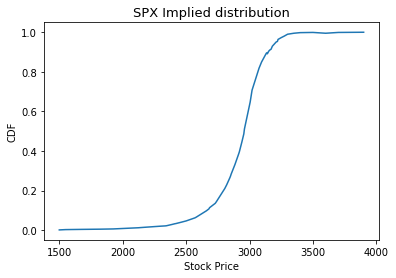

In [17]:
plt.plot(K_1[:-1], cdf_1)
plt.title("SPX Implied distribution", size=13)
plt.xlabel("Stock Price")
plt.ylabel("CDF")
plt.show()

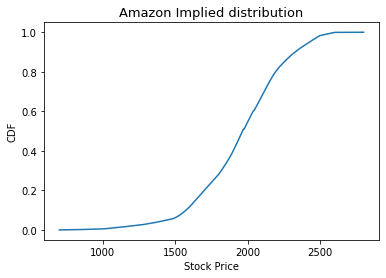

In [16]:
plt.plot(K_2[:-1], cdf_2)
plt.title("Amazon Implied distribution", size=13)
plt.xlabel("Stock Price")
plt.ylabel("CDF")
plt.show()

In [20]:
# 3. Follow the algorthm in slide 14 to obtain a set of option prices.

mu = np.array([0, 0])
cov = np.array([[1, rho], [rho, 1]])
X = np.random.multivariate_normal(mu, cov, size=num_sim)
x1 = stats.norm.cdf(X[:, 0])
x2 = stats.norm.cdf(X[:, 1])

# inverse sampling
imp_cdf_1 = interpolate.interp1d(cdf_1, K_1[:-1], fill_value="extrapolate")
imp_cdf_2 = interpolate.interp1d(cdf_2, K_2[:-1], fill_value="extrapolate")

inv_1 = lambda x: imp_cdf_1(x) - x1 # find the root x=S_T such that imp_cdf_1(S_T) = X_1 = normcdf(X)
inv_2 = lambda x: imp_cdf_2(x) - x2

S1T = inv_1(x1)
S2T = inv_2(x2)

# NOTE: the above could also be reduced to the following two lines:
#S1_T = interpolate.interp1d(cdf_1, K_1[:-1], fill_value="extrapolate")(x1)
#S2_T = interpolate.interp1d(cdf_2, K_2[:-1], fill_value="extrapolate")(x2)

In [21]:
# payoffs simulated
payoffs = np.maximum(S1T/S0_1 - S2T/S0_2, np.zeros(num_sim)) 

In [22]:
price_today = np.exp(-r*T)*np.mean(payoffs)

In [23]:
price_today

0.05792404384753558

In [24]:
stats.sem(payoffs)

0.0008817792140348615